# Generic Model for Sustainer Program

Building generic model
- Exclude "age", "member_t12m" variables in generic model

What's included in this Analysis:
1. Load the libraries
2. Load the cleaned final datasets (5 years)
3. Outlier Detection
4. Multicolliearity
5. Exploring Machine Learning Models
6. Feature Selection with Random Forest

## 1. Load the libraries

In [47]:
from pathlib import Path
import pandas as pd
import numpy as np

import itertools
from tqdm import tqdm

from statsmodels.stats.outliers_influence import variance_inflation_factor

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import model_selection
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import RFE
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

In [2]:
# get current directory
cwd = Path.cwd()


## 2. Load the cleaned datasets (5 years)

In [3]:
# read in 6 datasets from clients
veteran = pd.read_csv(cwd.joinpath('veteran_data_final.csv')) 
envr = pd.read_csv(cwd.joinpath('envr_data_final.csv')) 
advcy = pd.read_csv(cwd.joinpath('advcy_data_final.csv')) 
social = pd.read_csv(cwd.joinpath('social_data_final.csv')) 
health = pd.read_csv(cwd.joinpath('health_data_final.csv')) 
health2 = pd.read_csv(cwd.joinpath('health2_data_final.csv')) 

In [4]:
df = pd.concat([veteran, envr, advcy, social, health, health2])
df.shape

(460190, 31)

In [5]:
df.columns

Index(['sustainer', 'gender', 'client_state_rank', 'all_state_rank',
       'client_zip_rank', 'all_zip_rank', 'age', 'account_id', 'gift_date',
       'gift_min_t12m', 'gift_max_t12m', 'gift_avg_t12m', 'gift_count_t12m',
       'promo_count_t12m', 'cons_month_t12m', 'dm_t12m', 'tm_t12m', 'wm_t12m',
       'digital_t12m', 'f2f_t12m', 'events_t12m', 'drtv_t12m', 'other_t12m',
       'no_channel_t12m', 'member_t12m', 'gift_min_lt', 'gift_max_lt',
       'gift_avg_lt', 'gift_count_lt', 'promo_count_lt', 'cons_month_lt'],
      dtype='object')

### Exclued variables for genertic model

In [6]:
ex_vars = ['age', 'account_id', 'gift_date', 'member_t12m']

In [7]:
df_gen = df[df.columns.difference(ex_vars)]

In [8]:
df_gen.shape

(460190, 27)

In [9]:
df_gen.columns

Index(['all_state_rank', 'all_zip_rank', 'client_state_rank',
       'client_zip_rank', 'cons_month_lt', 'cons_month_t12m', 'digital_t12m',
       'dm_t12m', 'drtv_t12m', 'events_t12m', 'f2f_t12m', 'gender',
       'gift_avg_lt', 'gift_avg_t12m', 'gift_count_lt', 'gift_count_t12m',
       'gift_max_lt', 'gift_max_t12m', 'gift_min_lt', 'gift_min_t12m',
       'no_channel_t12m', 'other_t12m', 'promo_count_lt', 'promo_count_t12m',
       'sustainer', 'tm_t12m', 'wm_t12m'],
      dtype='object')

# 3. Outlier Detection

In [10]:
def get_skewed_columns(df):
    """
    :param df: dataframe where the skewed columns need to determined
    :return: skew_cols: dataframe with the skewed columns
    """
    skew_limit = 1  # define a limit above which we will handle later
    skew_vals = df.skew()
    # Showing the skewed columns
    skew_cols = (skew_vals
                 .sort_values(ascending=False)
                 .to_frame()
                 .rename(columns={0: 'Skew'})
                 .query('abs(Skew) > {}'.format(skew_limit)))
    return skew_cols

In [11]:
skewed_vars = get_skewed_columns(df_gen)

In [12]:
skewed_vars.shape

(24, 1)

In [13]:
## expensive to run
# sns.histplot(df_gen)

### 3.1 IQR

In [14]:
def remove_outliers_iqr(data, threshold=1.5):
    q1 = np.percentile(data, 25)
    q3 = np.percentile(data, 75)
    iqr = q3 - q1
    lower_bound = q1 - threshold * iqr
    upper_bound = q3 + threshold * iqr
    outliers_removed = data[(data >= lower_bound) & (data <= upper_bound)]
    return outliers_removed

### 3.2 Log Transformation
Log can only handle numeric variables that non negative or zeroes

## 4. Multicollinearity Using VIF

In [15]:
# separate data into label and features
def sep_var(df):
    labels = df['sustainer']
    features = df[df.columns.difference(['sustainer'])]
    return labels, features

In [16]:
labels, features = sep_var(df_gen)

In [17]:
def calculate_vif(features):
    vif = pd.DataFrame()
    vif["Features"] = features.columns
    vif["VIF"] = [variance_inflation_factor(features.values, i) for i in range(features.shape[1])]    
    return(vif)

In [18]:
vif = calculate_vif(features)
while vif['VIF'][vif['VIF'] > 5].any():
    remove = vif.sort_values('VIF',ascending=0)['Features'][:1]
    features.drop(remove,axis=1,inplace=True)
    vif = calculate_vif(features)

/var/folders/vw/bwhl53b17ylb4b159f3r6bhm0000gn/T/ipykernel_76479/776515595.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features.drop(remove,axis=1,inplace=True)
/var/folders/vw/bwhl53b17ylb4b159f3r6bhm0000gn/T/ipykernel_76479/776515595.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features.drop(remove,axis=1,inplace=True)
/var/folders/vw/bwhl53b17ylb4b159f3r6bhm0000gn/T/ipykernel_76479/776515595.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returni

In [19]:
len(vif['Features'])

18

### correlation heatmap of refined features

<Axes: >

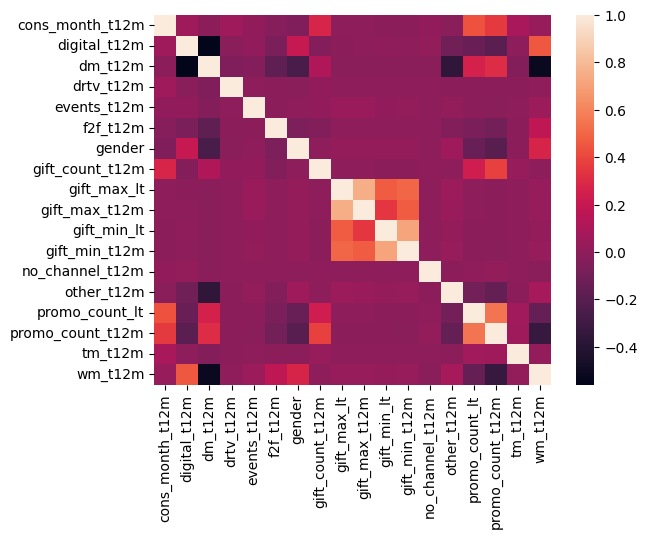

In [20]:
sns.heatmap(features.corr())

# 5. Exploring Machine Learning Models

In [21]:
seed = 444
scoring = 'accuracy'
array = features.values

X = array[:,1:]
test_size = 0.2

X_train, X_test, Y_train, Y_test = model_selection.train_test_split(X, labels, test_size=test_size, random_state=seed, shuffle=True)


In [26]:
models = []
models.append(('LR', LogisticRegression()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('RF', RandomForestClassifier()))
models.append(('NN',MLPClassifier()))
# models.append(('GBC', GradientBoostingClassifier)) train in separate 


In [27]:
# evaluate each model in turn
results = []
names = []
for name, model in models:
	kfold = model_selection.KFold(n_splits=10, random_state=seed,shuffle=True)
	cv_results = model_selection.cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
	results.append(cv_results)
	names.append(name)
	msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
	print(msg)

/Users/qiy/miniconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/qiy/miniconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regr

LR: 0.791111 (0.002142)
KNN: 0.902687 (0.001461)
CART: 0.918629 (0.001403)
RF: 0.933560 (0.001060)


/Users/qiy/miniconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:698: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


In [22]:
gbc = GradientBoostingClassifier()
gbc.fit(X_train, Y_train)
pred_y = gbc.predict(X_test)
acc = accuracy_score(Y_test, pred_y)
acc

0.8960212086312176

## 6. Feature Selection with Random Forest

In [23]:
from itertools import compress

In [ ]:
rf =RandomForestClassifier()
rfe = RFE(estimator=rf, n_features_to_select=10, step=1)
rfe.fit(X_train, Y_train)

In [31]:
l = features.columns.values[1:]
b = rfe.get_support(indices=False)

print(list(compress(l, b)))

['digital_t12m', 'gift_count_t12m', 'gift_max_lt', 'gift_max_t12m', 'gift_min_lt', 'gift_min_t12m', 'other_t12m', 'promo_count_lt', 'promo_count_t12m', 'wm_t12m']


### Train the model with selected features

In [25]:

rf = RandomForestClassifier()
rf.fit(X_train[:,b], Y_train)

predictions_rf = rf.predict(X_test[:,b])

print('accuracy_rf')
print(accuracy_score(Y_test, predictions_rf),'\n')

TN, FP, FN, TP = confusion_matrix(Y_test, predictions_rf).ravel()
print('Confusion Matrix')
print(confusion_matrix(Y_test, predictions_rf),'\n')

accuracy_rf
0.9277906951476564 

Confusion Matrix
[[70490  2517]
 [ 4129 14902]] 



In [48]:
cm = confusion_matrix(Y_test, predictions_rf)

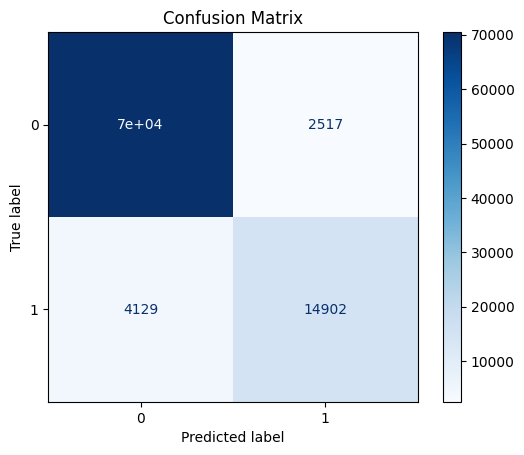

In [50]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()
